# Theory

The Bremmer modelling can be described as iterative modelling of sequential recomputation of downgoing and upgoing wavefields. In the elastic case we have P and pseudo-S downgoing wavefields:
$$\mathbf{D}_n=\sum_{m<n}\mathbf{W}_m\delta\mathbf{S}_m^+, \quad \mathbf{U}_n=\sum_{m>n}\mathbf{W}_m\delta\mathbf{S}_m^-,$$
where $\mathbf{D}=[{P}^+;{S}^+]$ is a matrix that includes downgoing P- and S-wavefields and $\mathbf{U}=[{P}^-;{S}^-]$ contains upgoing version of these wavefields. The scattering term $\delta\mathbf{S}^{\pm}=[\delta{S}_p^{\pm};\delta{S}_s^{\pm}]$ includes reflection and transmission operators at the specific depth level. In more detail, these operators are defined as:
$$\delta{S}^+_p={T}^+_{pp}{P}^+_{i-1}+{R}^{\cap}_{pp}{P}^-_{i-1}+{T}^+_{sp}{S}^+_{i-1}+{R}^{\cap}_{sp}{S}^-_{i-1},$$
$$\delta{S}^+_s={T}^+_{ss}{S}^+_{i-1}+{R}^{\cap}_{ss}{S}^-_{i-1}+{T}^+_{ps}{P}^+_{i-1}+{R}^{\cap}_{ps}{P}^-_{i-1},$$
$$\delta{S}^-_p={T}^-_{pp}{P}^-_{i-1}+{R}^{\cup}_{pp}{P}^+_{i-1}+{T}^-_{sp}{S}^-_{i-1}+{R}^{\cup}_{sp}{S}^+_{i-1},$$
$$\delta{S}^-_s={T}^-_{ss}{S}^-_{i-1}+{R}^{\cup}_{ss}{S}^+_{i-1}+{T}^-_{ps}{P}^-_{i-1}+{R}^{\cup}_{ps}{P}^+_{i-1}.$$ 

# Notebook info 

In this demo we will simulate 1.5 (elastic) fwmod using reflectivity and transmission operators derived by Zoeppritz equations

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import interactive
interactive(True)

In [19]:
#define 1.5d elastic fwmod function
def taper(input,taper):
    a=np.fft.ifft(input,axis=-1)
    b=taper*a
    c=np.fft.fft(b,axis=-1)#[...,:a.shape[-1]//2]
    return c
def fwmod_elastic(vp,vs,rho,nf,df, nx=100, dx=10, dz=10, surfmul=0, orders=0, alpha=-1.0, wavelet=None, wav=None):

    nkx = nx
    w = np.hstack((np.arange(0, nf))).reshape((-1, 1)) * 2 * m.pi * df + 1j * alpha
    kx = np.hstack((np.arange(0, (nx / 2)), np.arange(-(nx / 2), 0))) * 2 * m.pi / nx / dx
    kx1 = kx
    kx2 = kx ** 2

    nz=np.squeeze(vp).shape[0]

    pplus = (1 + 0j) * np.zeros((nz, nf, nkx))
    pminus = (1 + 0j) * np.zeros((nz, nf, nkx))
    splus = (1 + 0j) * np.zeros((nz, nf, nkx))
    sminus = (1 + 0j) * np.zeros((nz, nf, nkx))

    for iorder in range(orders):
        p = (1 + 0j) * np.zeros((nf, nkx))
        s = (1 + 0j) * np.zeros((nf, nkx))
        p[:] = 1 + 0j
        #s[:] = 1 + 0j

        for iz in range(0, nz - 1, 1):

            k = w / vp[iz]  # @

            tap = np.ones((1, nx))
            npad = 20

            tap[:, :npad] = np.linspace(0, 1, npad)
            tap[:, -npad:] = tap[:, npad - 1::-1]
            tap = np.roll(tap, nx // 2, axis=-1)

            kpup2 = (k ** 2) * np.ones((1, nkx))
            kzpup = kzupp = np.conj(np.sqrt((1 + 0j) * kpup2 - kx ** 2))


            k = w / vs[iz]  # @
            ksup2 = (k ** 2) * np.ones((1, nkx))
            kzsup = kzupp = np.conj(np.sqrt((1 + 0j) * ksup2 - kx ** 2))

            # define kz(kx,w) lower layer for P-waves
            # k = w / self.vp[iz]
            k = w / vp[iz + 1]  # @
            kplow2 = (k ** 2) * np.ones((1, nkx))
            kzplow = kzlow = np.conj(np.sqrt((1 + 0j) * kplow2 - kx ** 2))

            # define kz(kx,w) lower layer for S-waves
            # k = w / self.vs[iz]
            k = w / vs[iz + 1]  # @
            kslow2 = (k ** 2) * np.ones((1, nkx))
            kzslow = kzlow = np.conj(np.sqrt((1 + 0j) * kslow2 - kx ** 2))

            # get densities
            # rhoup=self.rho[iz-1]
            # rholow=self.rho[iz]
            rhoup = rho[iz]  # @
            rholow = rho[iz + 1]  # @

            # get velocities
            # cpup = self.vp[iz - 1]
            # csup = self.vs[iz - 1]
            # cplow = self.vp[iz]
            # cslow = self.vs[iz]
            cpup = vp[iz]  # @
            csup = vs[iz]  # @
            cplow = vp[iz + 1]  # @
            cslow = vs[iz + 1]  # @

        
            # define intermediate variables, stabilize inversion for w=0
            a = rhoup * (1 - 2 * kx2 / ksup2) - rholow * (1 - 2 * kx2 / kslow2)
            b = rhoup * (1 - 2 * kx2 / ksup2) + 2 * rholow * kx2 / kslow2
            c = rholow * (1 - 2 * kx2 / kslow2) + 2 * rhoup * kx2 / ksup2
            d = 2 * (rhoup / ksup2 - rholow / kslow2)
            a[0, ...] = 0.0
            b[0, ...] = 0.0
            c[0, ...] = 0.0
            d[0, ...] = 0.0
            e = kzplow * b + kzpup * c
            f = kzslow * b + kzsup * c
            g = a - d * kzplow * kzsup
            h = a - d * kzpup * kzslow

            # determinant and its stabilized inverse
            det = e * f + g * h * kx2
            detinv = 0* det
            stab=5000
            detinv[abs(det) > stab] = 1 / det[abs(det) > stab]

            rdpp = ((-kzplow * b + kzpup * c) * f - (a + kzpup * kzslow * d) * g * kx2) * detinv
            rdsp = 2 * kzpup * cpup / csup * kx1 * (a * c + b * d * kzplow * kzslow) * detinv
            rdps = 2 * kzsup * csup / cpup * kx1 * (a * c + b * d * kzslow * kzplow) * detinv
            rdss = -((-kzslow * b + kzsup * c) * e - kx2 * (kzsup * kzplow * d + a) * h) * detinv

            rupp = ((-kzpup * c + kzplow * b) * f - kx2 * (a + kzsup * kzplow * d) * h) * detinv
            rusp = -2 * kzplow * cplow / cslow * kx1 * (a * b + c * d * kzsup * kzpup) * detinv
            rups = -2 * kzslow * cslow / cplow * kx1 * (a * b + c * d * kzsup * kzpup) * detinv
            russ = -((kzslow * b - kzsup * c) * e - kx2 * (a + kzslow * kzpup * d) * h) * detinv

            tdpp = 2 * rhoup * cpup / cplow * kzpup * f * detinv
            tdsp = -2 * rhoup * cpup / cslow * kx1 * kzpup * g * detinv
            tdps = 2 * rhoup * csup / cplow * kx1 * kzsup * h * detinv
            tdss = 2 * rhoup * csup / cslow * kzsup * e * detinv

            tupp = 2 * rholow * cplow / cpup * kzplow * f * detinv
            tusp = 2 * rholow * cplow / csup * kx1 * kzplow * h * detinv
            tups = -2 * rholow * cslow / cpup * kx1 * kzslow * g * detinv
            tuss = 2 * rholow * cslow / csup * kzslow * e * detinv

            wpoper = np.exp(-1j * kzpup * dz)
            wsoper = np.exp(-1j * kzsup * dz)

            # propagate
            p *= wpoper
            s *= wsoper

            # save wavefield
            pplus[iz + 1, ...] = p
            splus[iz + 1, ...] = s
            p = tdpp * p + rupp * pminus[iz + 1, ...] + tdsp * s + rusp * sminus[iz + 1, ...]
            s = tdss * s + russ * sminus[iz + 1, ...] + tdps * p + rups * pminus[iz + 1, ...]
            if iz % 10 == 0:
                p = taper(p, tap)
                s = taper(s, tap)

            # p = (tupp * p + rdpp * pminus[iz+1, ...] + tusp * s + rdsp * sminus[iz+1, ...])
            # s = (tuss * s + rdss * sminus[iz+1, ...] + tups * p + rdps * pminus[iz+1, ...])

        p *= 0
        s *= 0

        for iz in range(nz - 1, 0, -1):

            # define kz(kx,w) upper layer for P-waves
            k = w / vp[iz - 1]

            tap = np.ones((1, nx))
            npad = 20
            tap[:, :npad] = np.linspace(0, 1, npad)
            tap[:, -npad:] = tap[:, npad - 1::-1]
            tap = np.roll(tap, nx // 2, axis=-1)

            kpup2 = (k ** 2) * np.ones((1, nkx))
            kzpup = kzupp = np.conj(np.sqrt((1 + 0j) * kpup2 - kx ** 2))

            # define kz(kx,w) upper layer for P-waves
            k = w / vs[iz - 1]
            ksup2 = (k ** 2) * np.ones((1, nkx))
            kzsup = kzupp = np.conj(np.sqrt((1 + 0j) * ksup2 - kx ** 2))

            # define kz(kx,w) lower layer for P-waves
            k = w / vp[iz]
            kplow2 = (k ** 2) * np.ones((1, nkx))
            kzplow = kzlow = np.conj(np.sqrt((1 + 0j) * kplow2 - kx ** 2))

            # define kz(kx,w) lower layer for S-waves
            k = w / vs[iz]
            kslow2 = (k ** 2) * np.ones((1, nkx))
            kzslow = kzlow = np.conj(np.sqrt((1 + 0j) * kslow2 - kx ** 2))

            # get densities
            rhoup = rho[iz - 1]
            rholow = rho[iz]

           
            # get velocities
            cpup = vp[iz - 1]
            csup = vs[iz - 1]
            cplow = vp[iz]
            cslow = vs[iz]

            # define intermediate variables, stabilize inversion for w=0
            a = rhoup * (1 - 2 * kx2 / ksup2) - rholow * (1 - 2 * kx2 / kslow2)
            b = rhoup * (1 - 2 * kx2 / ksup2) + 2 * rholow * kx2 / kslow2
            c = rholow * (1 - 2 * kx2 / kslow2) + 2 * rhoup * kx2 / ksup2
            d = 2 * (rhoup / ksup2 - rholow / kslow2)

            a[0, ...] = 0.0
            b[0, ...] = 0.0
            c[0, ...] = 0.0
            d[0, ...] = 0.0
            e = kzplow * b + kzpup * c
            f = kzslow * b + kzsup * c
            g = a - d * kzplow * kzsup
            h = a - d * kzpup * kzslow

            # determinant and its stabilized inverse
            det = e * f + g * h * kx2
            detinv = 0.0 * det
            detinv[abs(det) > 500] = 1 / det[abs(det) > 500]

            # create layer reflectivity and transmission operators

            rdpp = ((-kzplow * b + kzpup * c) * f - (a + kzpup * kzslow * d) * g * kx2) * detinv
            rdsp = 2 * kzpup * cpup / csup * kx1 * (a * c + b * d * kzplow * kzslow) * detinv
            rdps = 2 * kzsup * csup / cpup * kx1 * (a * c + b * d * kzslow * kzplow) * detinv
            rdss = -((-kzslow * b + kzsup * c) * e - kx2 * (kzsup * kzplow * d + a) * h) * detinv

            rupp = ((-kzpup * c + kzplow * b) * f - kx2 * (a + kzsup * kzplow * d) * h) * detinv
            rusp = -2 * kzplow * cplow / cslow * kx1 * (a * b + c * d * kzsup * kzpup) * detinv
            rups = -2 * kzslow * cslow / cplow * kx1 * (a * b + c * d * kzsup * kzpup) * detinv
            russ = -((kzslow * b - kzsup * c) * e - kx2 * (a + kzslow * kzpup * d) * h) * detinv

            tdpp = 2 * rhoup * cpup / cplow * kzpup * f * detinv
            tdsp = -2 * rhoup * cpup / cslow * kx1 * kzpup * g * detinv
            tdps = 2 * rhoup * csup / cplow * kx1 * kzsup * h * detinv
            tdss = 2 * rhoup * csup / cslow * kzsup * e * detinv

            tupp = 2 * rholow * cplow / cpup * kzplow * f * detinv
            tusp = 2 * rholow * cplow / csup * kx1 * kzplow * h * detinv
            tups = -2 * rholow * cslow / cpup * kx1 * kzslow * g * detinv
            tuss = 2 * rholow * cslow / csup * kzslow * e * detinv

            wpoper = np.exp(-1j * kzpup * dz)
            wsoper = np.exp(-1j * kzsup * dz)

            ##fwmod part
            # include scattering
            p = tupp * p + rdpp * pplus[iz, ...] + tusp * s + rdsp * splus[iz, ...]
            s = tuss * s + rdss * splus[iz, ...] + tups * p + rdps * pplus[iz, ...]

            # propagate
            p *= wpoper
            s *= wsoper
            if iz % 10 == 0:
                p = taper(p, tap)
                s = taper(s, tap)

            pminus[iz - 1, ...] = p
            sminus[iz - 1, ...] = s

    if wavelet:
        p *= wavelet
        s *= wavelet

    time_ax = dt * np.arange(0, nt).reshape((-1, 1))

    if wav is not None:
        wav_w = np.fft.fft(wav).reshape((-1, 1))
        p *= wav_w
        s *= wav_w

    p = np.real(np.fft.ifft(p, n=nt,axis=0))
    s =  np.real(np.fft.ifft(s, n=nt,axis=0))

    #pplus =  np.real(np.fft.ifft(pplus, n=nt,axis=0))
    #splus = np.real(np.fft.ifft(splus, n=nt,axis=0))
    #pminus =  np.real(np.fft.ifft(pminus, n=nt,axis=0))
    #sminus =  np.real(np.fft.ifft(sminus, n=nt,axis=0))
    p = np.exp(-alpha * time_ax) * np.roll(np.real(np.fft.ifft2(p, s=(nt, nx))), int(nx / 2), axis=-1)
    s = np.exp(-alpha * time_ax) * np.roll(np.real(np.fft.ifft2(s, s=(nt, nx))), int(nx / 2), axis=-1)

    pplus = np.exp(-alpha * time_ax) * np.roll(np.real(np.fft.ifft2(pplus, s=(nt, nx))), int(nx / 2),axis=-1)
    splus = np.exp(-alpha * time_ax) * np.roll(np.real(np.fft.ifft2(splus, s=(nt, nx))),int(nx / 2), axis=-1)
    pminus = np.exp(-alpha * time_ax) * np.roll(np.real(np.fft.ifft2(pminus, s=(nt, nx))), int(nx / 2),axis=-1)
    sminus = np.exp(-alpha * time_ax) * np.roll(np.real(np.fft.ifft2(sminus, s=(nt, nx))), int(nx / 2),axis=-1)
    
    return p, s, pplus, splus, pminus, sminus

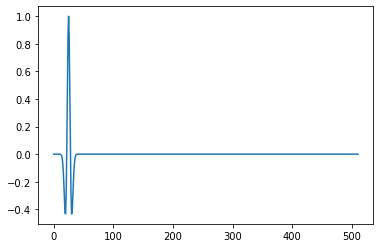

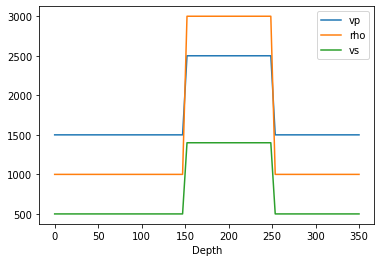

In [41]:
#define model and run modelling
nx=500
nz=70
vp=1500*np.ones((1,nz))
vs=500*np.ones((1,nz))
rho=1000*np.ones((1,nz))
case=1
if case==1:

  r=np.zeros((1,nz))
  vp[:,30:50]=2500
  vs[:,30:50]=1400
  rho[:,30:50]=3000

if case==2:
  vp[:,:20]=1750
  vp[:,20:40]=2000
  vp[:,40:]=2250
  vs[:,:20]=500
  vs[:,20:40]=700
  vs[:,40:]=1100
  rho[:,:20]=1000
  rho[:,20:40]=3000
  rho[:,40:]=1000

dx=5
dz=5

#copy model from chapter




dt=0.004
nt=512

fmax=50
df=1/nt/dt
nw=int(fmax/df)
wav=np.ones((nw,))

def ricker(f, length=0.128, dt=0.001,t0=0.1):
    t = np.arange(0-t0, (length-dt)-t0, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t**2)) * np.exp(-(np.pi**2)*(f**2)*(t**2))
    return t, y
 
f = 0.75*fmax//2
_, y = ricker(f,nt*dt,dt)
plt.plot(y)
plt.show()
wav=np.fft.fft(y,n=nt)[:nw]

z=np.linspace(0,nz*dz,nz)


plt.plot(z,vp.T,label='vp')
plt.plot(z,rho.T,label='rho')
plt.plot(z,vs.T,label='vs')
plt.legend()
plt.xlabel('Depth')
plt.show()

#############
orders=2 # 1-primaries; 2 - first order int mul; 3 - second int mul, etc..
#############

p,s,pplus,splus,pminus,sminus = fwmod_elastic(vp[0,:].T,vs[0,:].T,rho[0,:].T,nw,df, nx=nx, dx=dx,dz=dz,alpha=1,orders=orders)

VSP Slider

In [42]:
@interact(ix=widgets.IntSlider(min=0, max=nx-1, step=1, value=nx//2))
def vsp(ix):
  #extent=[0,nx*dx/1000,nt*dt-dt,0]
  vsp_extent=[0,nt*dt-dt,nz*dz/1000,0]
  fig, axs = plt.subplots(5)
  fig.set_figheight(14)
  fig.set_figwidth(12)
  axs[0].clear()
  clip=0.05*np.max(pplus)
  axs[0].imshow((pplus+pminus)[...,ix],extent=vsp_extent,cmap='gray',vmin=-clip,vmax=clip)
  axs[0].title.set_text('total p wavefield')
  axs[1].clear() 
  axs[1].imshow((pplus)[...,ix],extent=vsp_extent,cmap='gray',vmin=-clip,vmax=clip)
  axs[1].title.set_text('downgoing p wavefield')
  axs[2].clear() 
  axs[2].imshow((pminus)[...,ix],extent=vsp_extent,cmap='gray',vmin=-clip,vmax=clip)
  axs[2].title.set_text('downgoing p wavefield')
  axs[3].clear() 
  axs[3].imshow((splus)[...,ix],extent=vsp_extent,cmap='gray',vmin=-clip,vmax=clip)
  axs[3].title.set_text('downgoing s wavefield')
  axs[4].clear() 
  axs[4].imshow((sminus)[...,ix],extent=vsp_extent,cmap='gray',vmin=-clip,vmax=clip)
  axs[4].title.set_text('upgoing s wavefield')
  fig.text(0.5, 0.04, 'Time [s]', ha='center', va='center')
  fig.text(0.06, 0.5, 'Depth [km]', ha='center', va='center', rotation='vertical')
  #plt.title('... upgoing component')
  plt.show()
  

interactive(children=(IntSlider(value=250, description='ix', max=499), Output()), _dom_classes=('widget-intera…

Depth level slider:

In [43]:
@interact(iz=widgets.IntSlider(min=0, max=nz-1, step=1, value=1))
def depth(iz):
  fig, axs = plt.subplots(1,4)
  fig.set_figheight(10)
  fig.set_figwidth(14)
  extent = [0, nz*dz/1000, 0 + nt*dt, 0]
  clip=0.3*np.max(pminus)
  axs[0].clear() # <-- clear axes
  axs[0].imshow(pplus[iz,...],cmap='gray',extent=extent,aspect=0.5,vmin=-clip,vmax=clip)
  axs[0].title.set_text('downgoing p wavefield')
  #plt.title('... downgoing component')
  #plt.show()
  axs[1].clear() # <-- clear axes
  axs[1].imshow(pminus[iz,...],cmap='gray',extent=extent,aspect=0.5,vmin=-clip,vmax=clip)
  axs[1].title.set_text('upgoing p wavefield')

  axs[2].clear() # <-- clear axes
  axs[2].imshow(splus[iz,...],cmap='gray',extent=extent,aspect=0.5,vmin=-clip,vmax=clip)
  axs[2].title.set_text('downgoing s wavefield')
  #plt.title('... downgoing component')
  #plt.show()
  axs[3].clear() # <-- clear axes
  axs[3].imshow(sminus[iz,...],cmap='gray',extent=extent,aspect=0.5,vmin=-clip,vmax=clip)
  axs[3].title.set_text('upgoing s wavefield')
  fig.text(0.5, 0.04, 'Lateral location [m]', ha='center', va='center')
  fig.text(0.06, 0.5, 'Time [s]', ha='center', va='center', rotation='vertical')
  #plt.title('... upgoing component')
  plt.show()

interactive(children=(IntSlider(value=1, description='iz', max=69), Output()), _dom_classes=('widget-interact'…

Snapshot slider

In [44]:
@interact(it=widgets.IntSlider(min=0, max=nt-1, step=1, value=1))
def snap(it):
  fig, axs = plt.subplots(5,1)
  clip=0.3*np.max(pminus)
  fig.set_figheight(14)
  fig.set_figwidth(14)
  extent=[0,nx*dx,nz*dz,0]
  axs[0].clear() # <-- clear axes
  axs[0].imshow((pplus+pminus)[:,it,:],cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[3].title.set_text('total p wavefield')
  axs[1].clear() # <-- clear axes
  axs[1].imshow((pplus)[:,it,:],cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[1].title.set_text('downgoing p wavefield')
  axs[2].clear() # <-- clear axes
  axs[2].imshow((splus)[:,it,:],cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  axs[2].title.set_text('downgoing s wavefield')
  axs[3].clear() # <-- clear axes
  axs[3].imshow((pminus)[:,it,:],cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  fig.text(0.5, 0.04, 'Lateral location [m]', ha='center', va='center')
  fig.text(0.06, 0.5, 'Depth [m]', ha='center', va='center', rotation='vertical')
  axs[3].title.set_text('upgoing p wavefield')
  axs[4].clear() # <-- clear axes
  axs[4].imshow((sminus)[:,it,:],cmap='gray',extent=extent,vmin=-clip,vmax=clip)
  fig.text(0.5, 0.04, 'Lateral location [m]', ha='center', va='center')
  fig.text(0.06, 0.5, 'Depth [m]', ha='center', va='center', rotation='vertical')
  axs[4].title.set_text('upgoing s wavefield')
  #plt.title('... upgoing component')
  plt.show()
  #plt.imshow(np.real(np.fft.ifft(p,n=nt)).T)
  #plt.title('upgoing wavefield at the surface')
  #plt.show()
#[!!!] uncomment below, in case slider is not visible
#vsp(nx//2+20)
#depth(0)
#snap(30)

interactive(children=(IntSlider(value=1, description='it', max=511), Output()), _dom_classes=('widget-interact…